### 데이터 불러오기

In [ ]:
!pip install catboost
!pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 13.0 MB/s eta 0:00:00


In [ ]:
### 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold

### 폰트 설정
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

!apt-get install -qq fonts-nanum
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fm.fontManager.addfont(font_path)
plt.rc('font', family='NanumGothic')

Selecting previously unselected package fonts-nanum.
(Reading database ... 123598 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [ ]:
### 데이터
%cd '/content/drive/MyDrive/[2024-1] EURON 6기/프로젝트'
train = pd.read_csv('./review_train.csv', encoding='utf-8')
test = pd.read_csv('./review_test.csv', encoding='utf-8')
print(train.shape, test.shape)

/content/drive/MyDrive/[2024-1] EURON 6기/프로젝트
(2026, 2) (400, 2)


In [ ]:
### label encoding
from sklearn.preprocessing import LabelEncoder
n = train.shape[0]
y = pd.concat([train,test])

le = LabelEncoder()
y['keyword2'] = le.fit_transform(y['keyword2'])
train = y[:n]
test = y[n:]

### NLP

In [ ]:
### okt
from konlpy.tag import Okt
okt = Okt()
train['okt'] = train['reviews'].apply(okt.morphs)
test['okt'] = test['reviews'].apply(okt.morphs)

In [ ]:
### 불용어 제거
with open('./new_stopwords.txt', 'r', encoding='utf-8') as file:
    stop_words = file.readlines()
stop_words = [word.strip() for word in stop_words]


def remove_stopwords(review):
    return [word for word in review if word not in stop_words]


train['okt'] = [remove_stopwords(review) for review in train['okt']]
test['okt'] = [remove_stopwords(review) for review in test['okt']]

In [ ]:
### TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_okt = TfidfVectorizer(tokenizer=okt.morphs, ngram_range=(1,2), min_df=2,
                            max_df=0.95, stop_words=stop_words)
tfidf_okt_matrix = tfidf_okt.fit_transform(train['reviews'])
tfidf_okt_matrix_test = tfidf_okt.transform(test['reviews'])

In [ ]:
### X/y split
X_train = tfidf_okt_matrix
y_train = train['keyword2']
X_test = tfidf_okt_matrix_test
y_test = test['keyword2']

### train/valid split
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, shuffle=True, random_state=2024
)

print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(1620, 92075) (406, 92075) (400, 92075)
(1620,) (406,) (400,)


### SVC

[SVC] Validation Loss = 1.8106
[SVC] Validation Accuracy = 0.9384
[SVC] Validation F1 Score = 0.9362
[SVC] Test Loss = 2.3256
[SVC] Test Accuracy = 0.395
[SVC] Test F1 Score = 0.3823


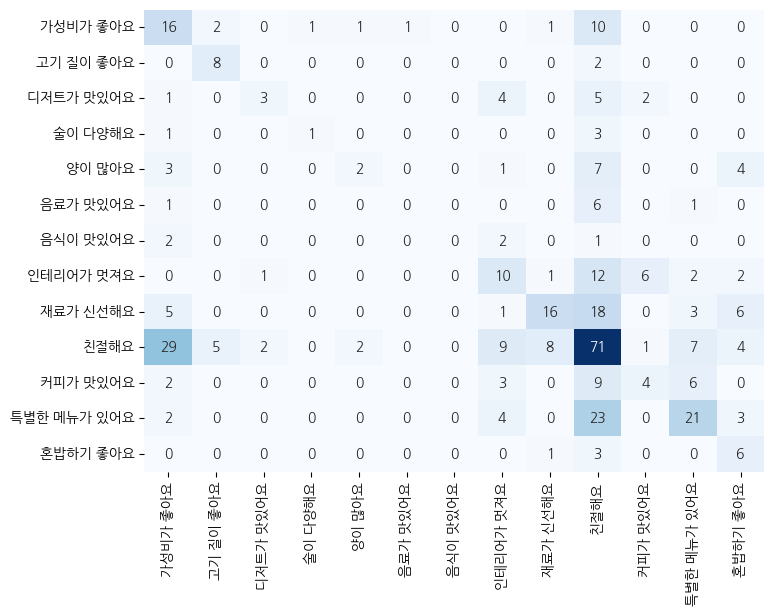

In [ ]:
### SVM
svm = SVC(C=10, kernel='rbf', gamma=0.1, random_state=2024, probability=True)
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_valid)
svm_proba = svm.predict_proba(X_valid)

valid_loss = loss_fn(torch.tensor(svm_proba), torch.tensor(y_valid.values, dtype=torch.long)).item()
valid_acc = accuracy_score(y_valid, svm_pred)
valid_f1 = f1_score(y_valid, svm_pred, average='weighted')
print(f'[SVC] Validation Loss = {round(valid_loss,4)}')
print(f'[SVC] Validation Accuracy = {round(valid_acc,4)}')
print(f'[SVC] Validation F1 Score = {round(valid_f1,4)}')

svm_test_pred = svm.predict(X_test)
svm_test_proba = svm.predict_proba(X_test)

test_loss = loss_fn(torch.tensor(svm_test_proba), torch.tensor(y_test.values, dtype=torch.long)).item()
test_acc = accuracy_score(y_test, svm_test_pred)
test_f1 = f1_score(y_test, svm_test_pred, average='weighted')
print(f'[SVC] Test Loss = {round(test_loss,4)}')
print(f'[SVC] Test Accuracy = {round(test_acc,4)}')
print(f'[SVC] Test F1 Score = {round(test_f1,4)}')

col = le.classes_
cm = confusion_matrix(y_test, svm_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=col, yticklabels=col)
plt.show()

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found: {'kernel': 'linear', 'gamma': 100.0, 'C': 10.0}
Best f1 score: 0.8924810328582096
[SVC] Validation Loss = 1.8108
[SVC] Validation Accuracy = 0.9384
[SVC] Validation F1 Score = 0.9361
[SVC] Test Loss = 2.3263
[SVC] Test Accuracy = 0.3925
[SVC] Test F1 Score = 0.3799


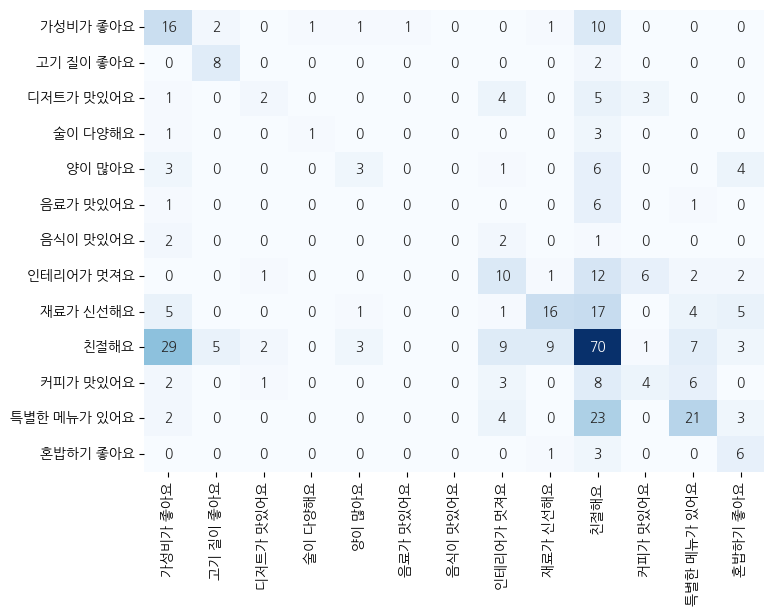

In [ ]:
### 랜덤서치
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'C': np.logspace(-3, 3, 7),  # 예: [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto'] + np.logspace(-3, 3, 7).tolist()  # 'scale'와 'auto'는 자동 계산 옵션, 나머지는 로그 스케일
}

random_search = RandomizedSearchCV(
    estimator=SVC(probability=True, random_state=2024),
    param_distributions=param_dist,
    n_iter=50,
    scoring='f1_weighted',
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=2024
)

random_search.fit(X_train, y_train)
print(f'Best parameters found: {random_search.best_params_}')
print(f'Best f1 score: {random_search.best_score_}')

best_svm = random_search.best_estimator_
svm_pred = best_svm.predict(X_valid)
svm_proba = best_svm.predict_proba(X_valid)

valid_loss = loss_fn(torch.tensor(svm_proba), torch.tensor(y_valid.values, dtype=torch.long)).item()
valid_acc = accuracy_score(y_valid, svm_pred)
valid_f1 = f1_score(y_valid, svm_pred, average='weighted')
print(f'[SVC] Validation Loss = {round(valid_loss,4)}')
print(f'[SVC] Validation Accuracy = {round(valid_acc,4)}')
print(f'[SVC] Validation F1 Score = {round(valid_f1,4)}')

svm_test_pred = best_svm.predict(X_test)
svm_test_proba = best_svm.predict_proba(X_test)

test_loss = loss_fn(torch.tensor(svm_test_proba), torch.tensor(y_test.values, dtype=torch.long)).item()
test_acc = accuracy_score(y_test, svm_test_pred)
test_f1 = f1_score(y_test, svm_test_pred, average='weighted')
print(f'[SVC] Test Loss = {round(test_loss,4)}')
print(f'[SVC] Test Accuracy = {round(test_acc,4)}')
print(f'[SVC] Test F1 Score = {round(test_f1,4)}')

col = le.classes_
cm = confusion_matrix(y_test, svm_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=col, yticklabels=col)
plt.show()

### XGB

In [ ]:
### loss function
import torch
import torch.nn as nn

loss_fn = nn.CrossEntropyLoss()

[XGBC] Validation Loss = 1.9071
[XGBC] Validation Accuracy = 0.8325
[XGBC] Validation F1 Score = 0.8248
[XGBC] Test Loss = 2.3442
[XGBC] Test Accuracy = 0.3675
[XGBC] Test F1 Score = 0.3637


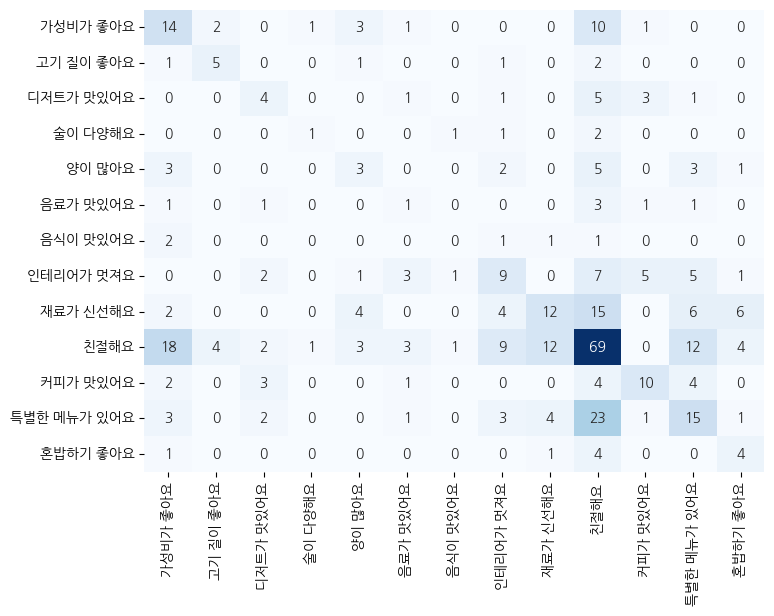

In [ ]:
### XGB
xgbc = XGBClassifier(n_estimators=500, learning_rate=0.3, max_depth=9,
                     min_child_weight=1, subsample=0.5, random_state=2024)
xgbc.fit(X_train, y_train)
xgbc_pred = xgbc.predict(X_valid)
xgbc_proba = xgbc.predict_proba(X_valid)

valid_loss = loss_fn(torch.tensor(xgbc_proba), torch.tensor(y_valid.values, dtype=torch.long)).item()
valid_acc = accuracy_score(y_valid, xgbc_pred)
valid_f1 = f1_score(y_valid, xgbc_pred, average='weighted')
print(f'[XGBC] Validation Loss = {round(valid_loss,4)}')
print(f'[XGBC] Validation Accuracy = {round(valid_acc,4)}')
print(f'[XGBC] Validation F1 Score = {round(valid_f1,4)}')

xgbc_test_pred = xgbc.predict(X_test)
xgbc_test_proba = xgbc.predict_proba(X_test)

test_loss = loss_fn(torch.tensor(xgbc_test_proba), torch.tensor(y_test.values, dtype=torch.long)).item()
test_acc = accuracy_score(y_test, xgbc_test_pred)
test_f1 = f1_score(y_test, xgbc_test_pred, average='weighted')
print(f'[XGBC] Test Loss = {round(test_loss,4)}')
print(f'[XGBC] Test Accuracy = {round(test_acc,4)}')
print(f'[XGBC] Test F1 Score = {round(test_f1,4)}')

col = le.classes_
cm = confusion_matrix(y_test, xgbc_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=col, yticklabels=col)
plt.show()

### LGBM

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

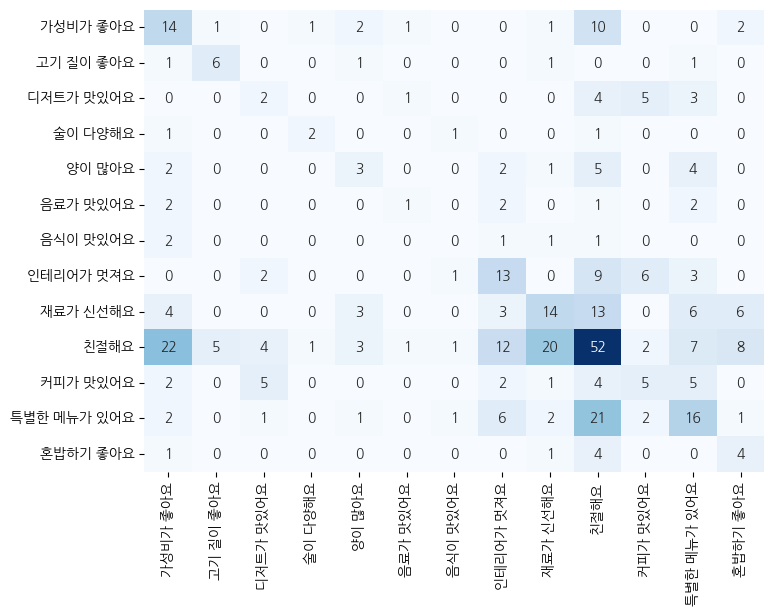

In [ ]:
### lgbm
lgbc = LGBMClassifier(n_estimators=1000, max_depth=10, learning_rate=0.2,
                      random_state=2024)
lgbc.fit(X_train, y_train)
lgbc_pred = lgbc.predict(X_valid)
lgbc_proba = lgbc.predict_proba(X_valid)

valid_loss = loss_fn(torch.tensor(lgbc_proba), torch.tensor(y_valid.values, dtype=torch.long)).item()
valid_acc = accuracy_score(y_valid, lgbc_pred)
valid_f1 = f1_score(y_valid, lgbc_pred, average='weighted')
print(f'[LGBC] Validation Loss = {round(valid_loss,4)}')
print(f'[LGBC] Validation Accuracy = {round(valid_acc,4)}')
print(f'[LGBC] Validation F1 Score = {round(valid_f1,4)}')

lgbc_test_pred = lgbc.predict(X_test)
lgbc_test_proba = lgbc.predict_proba(X_test)

test_loss = loss_fn(torch.tensor(lgbc_test_proba), torch.tensor(y_test.values, dtype=torch.long)).item()
test_acc = accuracy_score(y_test, lgbc_test_pred)
test_f1 = f1_score(y_test, lgbc_test_pred, average='weighted')
print(f'[LGBC] Test Loss = {round(test_loss,4)}')
print(f'[LGBC] Test Accuracy = {round(test_acc,4)}')
print(f'[LGBC] Test F1 Score = {round(test_f1,4)}')

col = le.classes_
cm = confusion_matrix(y_test, lgbc_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=col, yticklabels=col)
plt.show()